# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [106]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import io
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve




## 2. INICIALIZAR MEDIAPIPE

In [107]:
# Configuración inicial global
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1
)
mp_draw = mp.solutions.drawing_utils
dataset_dir = "dataset_9"
model_path = "gesture_model.h5"
sequence_length = 30 #90
total_landmarks = 126
gestures = []
X_mean = None
X_std = None

## 3. FUNCIONES PRINCIPALES

In [108]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(dataset_dir, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return [d for d in os.listdir(dataset_dir) 
           if os.path.isdir(os.path.join(dataset_dir, d))]

## 4. DETECCION DE MANO

In [109]:
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## 5. RECOLLECION DE DATOS 

In [110]:
def collect_data():
    global gestures
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(0)
    sequence = []
    counter = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        cv2.imshow("Recolección de Datos", frame)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")

## 6. CARGA DE DATOS

In [111]:
def load_data():
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(dataset_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
    
    return np.array(X), np.array(y), gestures


## 7. ENTRENAMIENTO DEL MODELO

In [112]:
def train_model():
    global X_mean, X_std, gestures
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data()
    y = tf.keras.utils.to_categorical(y)

    X_mean = np.mean(X, axis=(0, 1))
    X_std = np.std(X, axis=(0, 1))
    X = (X - X_mean) / X_std

    # Configurar TensorBoard
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=1,
        write_graph=True,
        write_images=True
    )
    
    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = tf.keras.layers.Dense(len(gestures), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )
    def generate_training_plots(history):
            plt.figure(figsize=(12, 5))
            
            # Gráfico de precisión
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión Validación')
            plt.title('Precisión durante Entrenamiento')
            plt.ylabel('Precisión')
            plt.xlabel('Época')
            plt.legend()
            
            # Gráfico de pérdida
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida Validación')
            plt.title('Pérdida durante Entrenamiento')
            plt.ylabel('Pérdida')
            plt.xlabel('Época')
            plt.legend()
            
            plt.tight_layout()
            plt.savefig('training_metrics.png')
            plt.show()

    def generate_confusion_matrix(model, X, y):
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(model.predict(X), axis=1)
            
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=gestures, 
                        yticklabels=gestures)
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicciones')
        plt.ylabel('Verdaderos')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
            
        # Imprimir reporte de clasificación
        print("\nReporte de Clasificación:")
        print(classification_report(y_true, y_pred, target_names=gestures))

    # Guardar modelo y generar gráficos
    model.save(model_path)
    generate_training_plots(history)
    generate_confusion_matrix(model, X, y)
    print(f"\nModelo guardado en {model_path}")
    
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

## 8. EVALUACION DEL MODELO

In [113]:
def evaluate():
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    model = load_model(model_path)
    print("\nCargando modelo y preparando evaluación...")
    
    sequence = []
    cap = cv2.VideoCapture(0)
    
    print("\nMostrando predicciones en tiempo real. Presiona 'ESC' para salir.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        
        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        else:
            sequence = []
        
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            try:
                seq_array = np.array(sequence)
                seq_array = (seq_array - X_mean) / X_std
                input_data = seq_array.reshape(1, sequence_length, total_landmarks)
                
                prediction = model.predict(input_data, verbose=0)[0]
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                
                if confidence > 0.8:
                    gesture = gestures[predicted_class]
                    cv2.putText(frame, f"{gesture} ({confidence:.2%})", (10, 50),
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            except Exception as e:
                print(f"\nError en predicción: {str(e)}")
                break

        cv2.imshow("Predicciones en Tiempo Real", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

In [114]:
def evaluate_with_plots():
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    # Cargar modelo y datos
    model = load_model(model_path)
    X, y, _ = load_data()
    y = tf.keras.utils.to_categorical(y)
    
    # Preprocesamiento
    X = (X - X_mean) / X_std
    
    # Predicciones
    y_pred = model.predict(X)
    y_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    
    # 1. Matriz de Confusión
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=gestures, yticklabels=gestures)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 2. Reporte de Clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_classes, target_names=gestures))

    # 3. Curvas ROC por Clase
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        fpr, tpr, _ = roc_curve(y_true, y_pred[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{gestures[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC por Clase')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Precisión vs Recall
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:,i], pos_label=i)
        plt.plot(recall, precision, label=gestures[i])
    
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curvas Precisión-Recall')
    plt.legend(loc="best")
    plt.show()

    # 5. Distribución de Probabilidades
    plt.figure(figsize=(10, 6))
    for i in range(len(gestures)):
        sns.kdeplot(y_pred[y_true == i][:,i], label=gestures[i])
    
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Densidad')
    plt.title('Distribución de Probabilidades por Clase')
    plt.legend()
    plt.show()


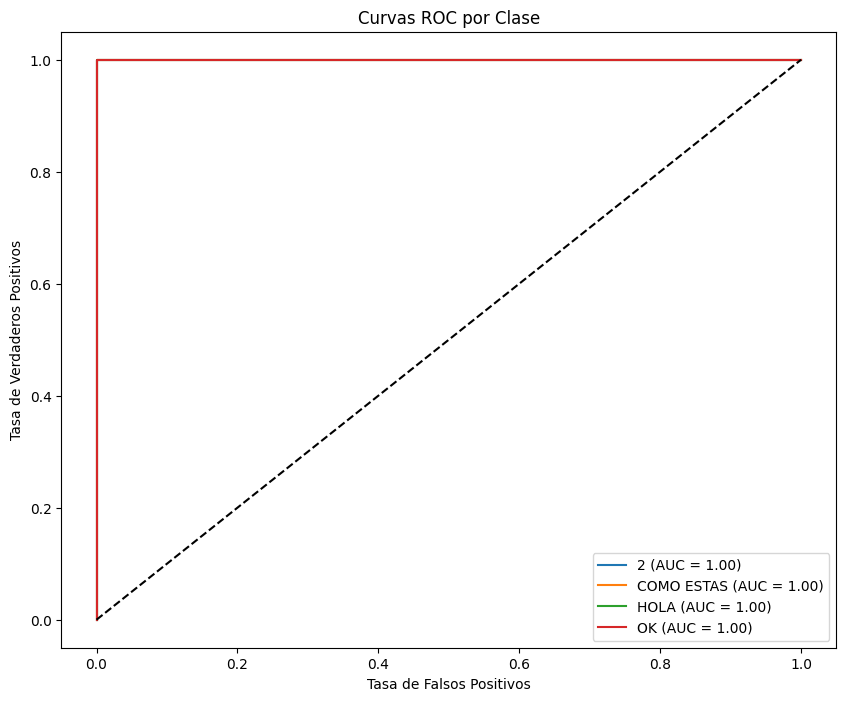

1. Curvas ROC por Clase
AUC = 1.00 para todas las clases ("COMO ESTAS", "HOLA", "OK"):

Indica un rendimiento perfecto del modelo, donde se logra el 100% de verdaderos positivos sin falsos positivos.

Posible motivo:

Sobreajuste (overfitting): El modelo memorizó los datos de entrenamiento y no generaliza bien.

Separación perfecta en los datos: Las clases están claramente diferenciadas en el espacio de características.

Ejes:

X: Tasa de Falsos Positivos (FPR)

Y: Tasa de Verdaderos Positivos (TPR)

Lectura:

Línea diagonal (---): Rendimiento aleatorio (AUC = 0.5).

Curvas cercanas a la esquina superior izquierda: Mejor rendimiento.

AUC (Área bajo la curva):

1.00 (como en tu caso): El modelo clasifica perfectamente todas las muestras.

Ejemplo: Si un gesto "HOLA" tiene AUC=1.0, el modelo nunca confunde "HOLA" con otros gestos

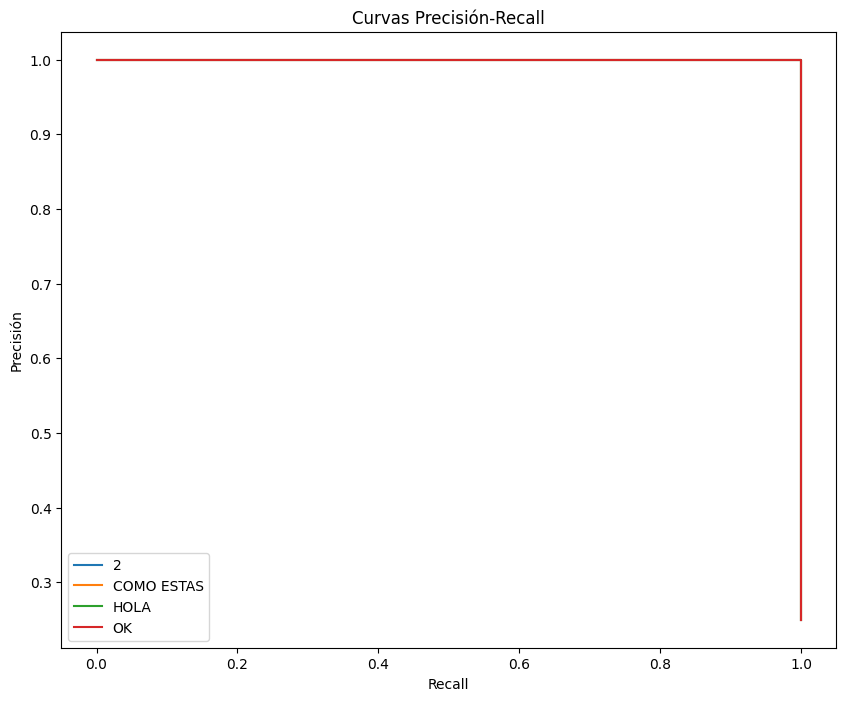

2. Curvas Precisión-Recall
Precisión alta (hasta 1.0):

El modelo casi no comete falsos positivos en ciertos umbrales.

Fluctuaciones en la precisión (0.3 a 1.0):

Sugiere que el rendimiento varía según el umbral de clasificación elegido.

Posible motivo:

Desequilibrio de clases: Si una clase es mayoritaria, la precisión puede ser engañosa.

Casos ambiguos: Algunos ejemplos son difíciles de clasificar, reduciendo la precisión en ciertos umbrales.

Ejes:

X: Recall (Sensibilidad)

Y: Precisión

Lectura:

Curva cercana a la esquina superior derecha: Mejor rendimiento.

Área alta bajo la curva: Buen equilibrio entre precisión y recall.

Ejemplo: Si "COMO ESTAS" tiene precisión=1.0 y recall=1.0, el modelo detecta todos los casos (recall alto) sin falsos positivos (precisión alta).

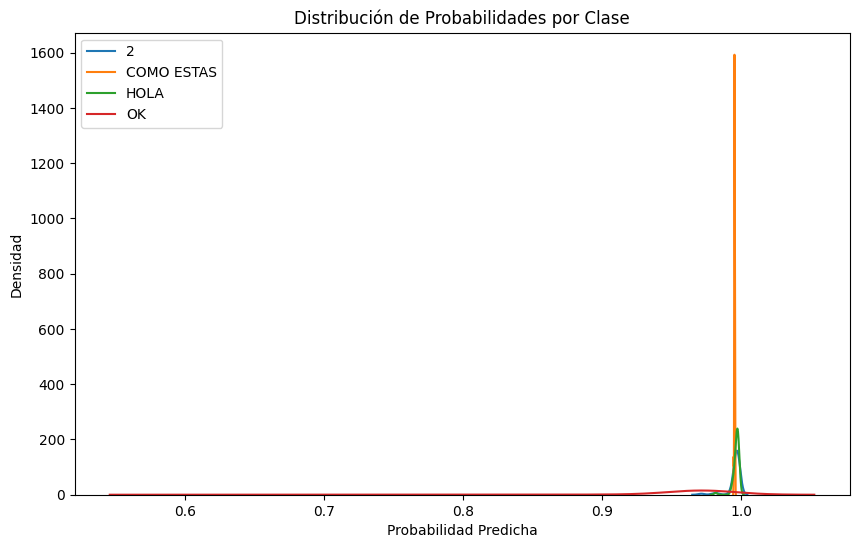

3. Distribución de Probabilidades por Clase
Probabilidades concentradas en 0.8–1.0:

El modelo está muy seguro de sus predicciones para todas las clases.

Ausencia de predicciones en rangos bajos (0.0–0.7):

Posible motivo:

Datos de entrenamiento "fáciles": Los ejemplos son muy similares entre sí.

Falta de diversidad en los datos: No hay casos ambiguos o ruidosos.

Ejes:

X: Probabilidad predicha (de 0 a 1).

Y: Densidad (frecuencia de predicciones).

Lectura:

Picos cerca de 1.0: El modelo está muy seguro de sus predicciones.

Distribución amplia: Incertidumbre en las predicciones.

-----------------------------

+ Conclusiones y Recomendaciones
Riesgo de sobreajuste:

Valide el modelo con datos nunca vistos durante el entrenamiento.

Aplique técnicas de regularización (Dropout, L2) o aumentación de datos.

Verificación de datos:

Revise si las clases están balanceadas.

Asegúrese de que los datos de entrenamiento y prueba no se solapen.

Robustez del modelo:

Incorpore ejemplos "difíciles" o ruidosos en el entrenamiento.

Evalúe métricas adicionales (F1-Score, Matriz de Confusión detallada).

En resumen, el modelo muestra un rendimiento aparentemente perfecto, pero estos resultados deben interpretarse con cautela. La validación externa es crítica para confirmar su capacidad de generalización.

## 9. REENTRENAR GESTO

In [115]:
def retrain_gesture():
    global gestures
    if not gestures:
        print("\nNo hay gestos para reentrenar. Primero recolecte datos.")
        return

    print("\nGestos disponibles para reentrenar:")
    for i, gesture in enumerate(gestures):
        print(f"{i+1}. {gesture}")

    try:
        choice = int(input("\nSeleccione el número del gesto a reentrenar: ")) - 1
        if 0 <= choice < len(gestures):
            gesture = gestures[choice]
            gesture_dir = os.path.join(dataset_dir, gesture)
            
            for file in os.listdir(gesture_dir):
                os.remove(os.path.join(gesture_dir, file))
            
            print(f"\nDatos anteriores de '{gesture}' eliminados.")
            collect_data()
            train_model()
        else:
            print("\nSelección inválida.")
    except ValueError:
        print("\nPor favor, ingrese un número válido.")

## 10. MENU

In [116]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo")
        print("4. Evaluar en Tiempo Real")
        print("5. Evaluar con Gráficos (Datos Grabados)")
        print("6. Reentrenar Gesto")
        print("7. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            collect_data()
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            evaluate_with_plots()
        elif choice == '6':
            retrain_gesture()
        elif choice == '7':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU

In [117]:
if __name__ == "__main__":
    main()


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar en Tiempo Real
5. Evaluar con Gráficos (Datos Grabados)
6. Reentrenar Gesto
7. Salir

Recolectando datos para el gesto 'CONSTRUIR'. Presiona 'ESC' para cancelar.
Mantenga la seña frente a la cámara...
Secuencias capturadas: 1/50
Secuencias capturadas: 2/50
Secuencias capturadas: 3/50
Secuencias capturadas: 4/50
Secuencias capturadas: 5/50
Secuencias capturadas: 6/50
Secuencias capturadas: 7/50

Se recolectaron 7 secuencias para el gesto 'CONSTRUIR'

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar en Tiempo Real
5. Evaluar con Gráficos (Datos Grabados)
6. Reentrenar Gesto
7. Salir

¡Hasta luego!
